# Matched UNIONS 800 deg^2 + ShapePipe shear catalogue
Need to join using CFIS_ID.

In [3]:
import numpy as np
import math

import pandas as pd
import matplotlib.pylab as plt

from astropy.io import fits
from astropy.coordinates import SkyCoord, match_coordinates_sky
import astropy.units as units

from collections import Counter

from functions import *

%matplotlib inline

### Read matched ShapePipe shear catalogue

In [4]:
base_name_sp = 'shape_catalog_ngmix'

hdu = fits.open(f'{base_name_sp}.fits')

data = hdu[1].data

In [5]:
# Print column names
data_keys = data.dtype.names
print(data_keys)

('ra', 'dec', 'g1', 'g2', 'w', 'mag', 'snr', 'g1_uncal', 'g2_uncal', 'CFIS_ID', 'RA', 'Dec', 'distance')


## Plots

### Spatial distribution

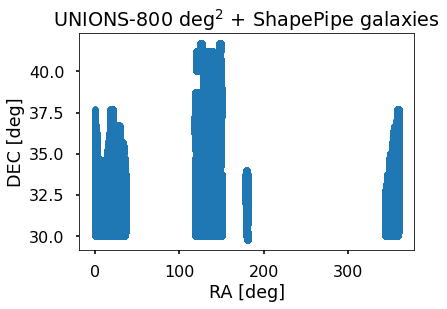

In [6]:
plt.plot(data['ra'], data['dec'], '.')
plt.title('UNIONS-800 deg$^2$ + ShapePipe galaxies')
plt.xlabel('RA [deg]')
_ = plt.ylabel('DEC [deg]')

In [7]:
def millify(n):
    """Millify

    Return human-readible names of large numbers

    Parameters
    ----------
    n : int
        input number

    Returns
    -------
    s : string
        output name
    """

    millnames = ['',' Thousand',' Million',' Billion',' Trillion']

    n = float(n)
    millidx = max(
        0,
        min(
            len(millnames) - 1,
            int(math.floor(0 if n == 0 else math.log10(abs(n)) / 3))
        )
    )

    return '{:.0f}{}'.format(n / 10**(3 * millidx), millnames[millidx])


In [8]:
ngal = len(data)
print(f'Number of galaxies = {ngal} = {millify(ngal)}')

Number of galaxies = 18015789 = 18 Million


### Magnitude distribution (r-band)

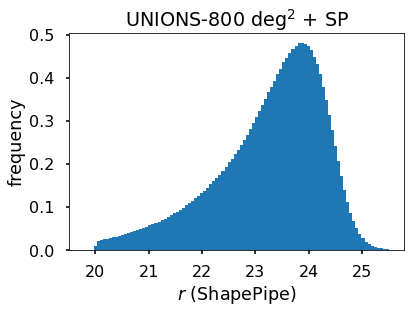

In [9]:
fig, (ax) = plt.subplots(1, 1)

range = (19.8, 25.5)

h = ax.hist(data['mag'], bins=100, density=True, range=range)
plt.title('UNIONS-800 deg$^2$ + SP')
plt.xlabel('$r$ (ShapePipe)')
plt.xticks(ticks=[20, 21, 22, 23, 24, 25])
_ = plt.ylabel('frequency')

### Read multi-band UNIONS catalogue

In [10]:
# UNIONS

# Full catalogue
base_name_ph = 'unions.ugriz2'

# Smaller catalogue
#base_name_ph = 'unions.ugriz_1M'

cat_ph = pd.read_csv(f'{base_name_ph}.tsv', delimiter='\s+')

In [11]:
print('Keys in UNIONS catalogue:')
mb_keys = cat_ph.keys()
print(mb_keys)
print(f'Number of UNIONS objects = {len(cat_ph)}')

Keys in UNIONS catalogue:
Index(['RA', 'Dec', 'CFIS_ID', 'CFIS_U_MAG_AUTO', 'CFIS_U_MAGERR_AUTO',
       'HSC_G_MAG_AUTO', 'HSC_G_MAGERR_AUTO', 'CFIS_R_MAG_AUTO',
       'CFIS_R_MAGERR_AUTO', 'PS_i_stk_kron', 'PS_i_stk_kron_err',
       'PS_z_stk_kron', 'PS_z_stk_kron_err', 'CFIS_R_StarGal'],
      dtype='object')
Number of UNIONS objects = 71948699


### Match the two catalogues acording to the CFIS galaxy ID

In [12]:
# Transform IDs back to int
cfis_id = data['CFIS_ID'].astype(int)

In [13]:
# Get indices of matches
xy, x_ind, y_ind = np.intersect1d(cfis_id, cat_ph['CFIS_ID'], return_indices=True)

In [14]:
# Check
print(cfis_id[x_ind][:10])
print(cat_ph['CFIS_ID'][y_ind][:10])

[2000240003934 2000240003986 2000240004011 2000240004028 2000240004036
 2000240004046 2000240004101 2000240004115 2000240004117 2000240004130]
0     2000240003934
21    2000240003986
38    2000240004011
44    2000240004028
48    2000240004036
56    2000240004046
84    2000240004101
87    2000240004115
89    2000240004117
96    2000240004130
Name: CFIS_ID, dtype: int64


In [15]:
len(cat_ph['CFIS_ID'][y_ind])

18008780

In [16]:
len(data)

18015789

In [17]:
# Create column array for SP catalogue
cols = []
for key in data_keys:
    print(key)
    if key != 'CFIS_ID':
        c = fits.Column(name=key, format='D', array=data[x_ind][key])
    else:
        dat = cfis_id
        c = fits.Column(name=key, format='I64', array=dat[x_ind])
    cols.append(c)

ra
dec
g1
g2
w
mag
snr
g1_uncal
g2_uncal
CFIS_ID
RA
Dec
distance


In [18]:
# Append columns from multi-band catalogue
for idx, key in enumerate(mb_keys):
    if key in ['RA', 'Dec']:
        # Coordinates in the matched MB+SP catalogue are exactly the same,
        # so we don't need them again
        continue
    elif key == 'CFIS_ID':
        # Add mb CFIS_ID for consistency check later
        key2 = f'{key}_mb'
    else:
        key2 = key
    print(key2)
    c = fits.Column(name=key2, format=cat_ph.dtypes[idx], array=cat_ph[key][y_ind])
    cols.append(c)

CFIS_ID_mb
CFIS_U_MAG_AUTO
CFIS_U_MAGERR_AUTO
HSC_G_MAG_AUTO
HSC_G_MAGERR_AUTO
CFIS_R_MAG_AUTO
CFIS_R_MAGERR_AUTO
PS_i_stk_kron
PS_i_stk_kron_err
PS_z_stk_kron
PS_z_stk_kron_err
CFIS_R_StarGal


In [ ]:
out_name = 'cfis_800d2_SP_v1.0.fits'
hdu_out = fits.BinTableHDU.from_columns(cols)
hdu_out.writeto(out_name)

In [ ]:
print('Saved FITS file f{out_name}')